# CIS 787 - Analytical Data Mining
<img src="https://www.syracuse.edu/wp-content/themes/g6-carbon/img/syracuse-university-seal.svg?ver=6.3.9" style="width: 200px;"/>
## Project Title: Comparing and Analyzing Prediction Models for Google Analytics Customer Revenue Prediction
### Project by: _Akshay Kacharaj Jagtap (352503517)_ and _Malhar Anup Ujawane(642560698)_

### Project Objective

-  Build prediction models to predict the revenue that a customer will generate based on training dataset

-  Compare the prediction models by evaluating factors such as accuracy, mean absolute error, RMSE etc.

-  Alter and analyze dataset to identify which features play significant roles in generating revenue, and how they affect the prediction model.

### About the dataset

#### We are given two datasets
-  train.csv
-  test.csv

#### The data fields in the given files are:

- _fullVisitorId_ - A unique identifier for each user of the Google Merchandise Store.
- _channelGrouping_ - The channel via which the user came to the Store.
- _date_ - The date on which the user visited the Store.
- _device_ - The specifications for the device used to access the Store.
- _geoNetwork_ - This section contains information about the geography of the user.
- _sessionId_ - A unique identifier for this visit to the store.
- _socialEngagementType_ - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
- _totals_ - This section contains aggregate values across the session.
- _trafficSource_ - This section contains information about the Traffic Source from which the session originated.
- _visitId_ - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
- _visitNumber_ - The session number for this user. If this is the first session, then this is set to 1.
- _visitStartTime_ - The timestamp (expressed as POSIX time).

#### Each row in the dataset is one visit to the store. We are predicting the natural log of the sum of all transactions per user.

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics


pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [2]:
train = pd.read_csv("train.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



#### We here confirmed that some columns have mixed type. In our case, we know that some columns have json blobs. 
#### The function _convert_loadJSON()_ below is used to convert all the json fields in the file to a flattened csv format.

In [3]:
def convert_loadJSON(csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [4]:
%%time
train_df = convert_loadJSON('train.csv')
test_df = convert_loadJSON("test.csv")

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
CPU times: user 5min 10s, sys: 3min 34s, total: 8min 44s
Wall time: 10min 17s


#### Let's see what we have in our training set.

In [5]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not a

#### Let's see what we have in our testing set.

In [6]:
test_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,Asia,Singapore,not available in demo dataset,not available in demo dataset,(not set),myrepublic.com.sg,not available in demo dataset,(not set),Southeast Asia,NaN,4,NaN,4,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google
1,Organic Search,20171016,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Zaragoza,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),rima-tde.net,not available in demo dataset,Aragon,Southern Europe,NaN,5,1,5,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20171016,6059383810968229466,6059383810968229466_1508143220,Not Socially Engaged,1508143220,1,1508143220,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Europe,France,not available in demo dataset,not available in demo dataset,not available in demo dataset,sfr.net,not available in demo dataset,not available in demo dataset,Western Europe,NaN,7,1,7,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20171016,2376720078563423631,2376720078563423631_1508193530,Not Socially Engaged,1508193530,1,1508193530,Safari,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in 

#### Our target feature is _transactionRevenue_ which we got from _totals_ column in the original training dataset. 
#### Let's group the users according to the _transactionRevenue_ feature. 

In [7]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
groupby_distribution = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

In [8]:
groupby_distribution.shape

(714167, 2)

In [9]:
groupby_distribution.head()

,fullVisitorId,totals.transactionRevenue
0,0000010278554503158,0.0
1,0000020424342248747,0.0
2,0000027376579751715,0.0
3,0000039460501403861,0.0
4,0000040862739425590,0.0


#### Let's plot this distribution

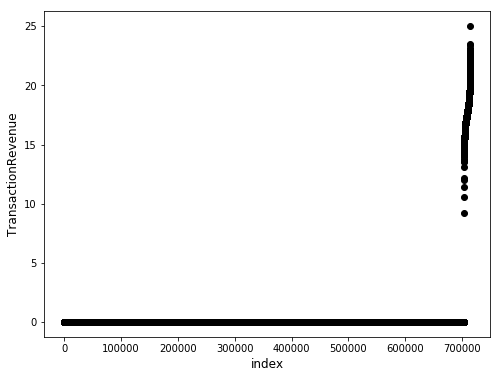

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(range(groupby_distribution.shape[0]), np.sort(np.log1p(groupby_distribution["totals.transactionRevenue"].values)),color='black')
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

#### This graph confirms the 80/20 rule - only a small percentage of customers produce most of the revenue.

#### First, let's see if there are any columns with constant values. 

In [11]:
constant_columns = [col for col in train_df.columns if train_df[col].nunique(dropna=False)==1 ]
constant_columns

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

#### We can remove the columns which have constant value and some null values. This way we can save some memory and time in our modeling process.

### Let's see how many unique users are there in given datasets.

In [12]:
nzi = pd.notnull(train_df["totals.transactionRevenue"]).sum()
nzr = (groupby_distribution["totals.transactionRevenue"]>0).sum()
print("Number of instances in train set with non-zero revenue : ", nzi, " and ratio is : ", nzi / train_df.shape[0])
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / groupby_distribution.shape[0])

Number of instances in train set with non-zero revenue :  11515  and ratio is :  0.0127427231470487
Number of unique customers with non-zero revenue :  9996 and the ratio is :  0.013996726255903731


### Since most of the rows have non-zero revenues, let's now have a look at the count of each category of the variables along with the number of instances where the revenue is not zero.

#### Feature: _fullVisitorId_:
#### Now let us look at the number of unique visitors in the train and test set and also the number of common visitors.

In [13]:
print("Number of unique visitors in train set : ",train_df.fullVisitorId.nunique(), " out of rows : ",train_df.shape[0])
print("Number of unique visitors in test set : ",test_df.fullVisitorId.nunique(), " out of rows : ",test_df.shape[0])
print("Number of common visitors in train and test set : ",len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))

Number of unique visitors in train set :  714167  out of rows :  903653
Number of unique visitors in test set :  617242  out of rows :  804684
Number of common visitors in train and test set :  7679


#### Feature: _channelGrouping_:
#### Now let us look at the number of unique channelGroupings in the train and test set and also the number of common channelGroupings.

In [14]:
print("Number of unique channelGroupings in train set : ",train_df.channelGrouping.nunique())
print("Number of unique channelGroupings in test set : ",test_df.channelGrouping.nunique())
print("Number of common channelGroupings in train and test set : ",len(set(train_df.channelGrouping.unique()).intersection(set(test_df.channelGrouping.unique())) ))

Number of unique channelGroupings in train set :  8
Number of unique channelGroupings in test set :  8
Number of common channelGroupings in train and test set :  8


#### Feature: _date_:
#### Now let us look at the number of unique dates in the train and test set and also the number of common dates.

In [15]:
print("Number of unique dates in train set : ",train_df.date.nunique())
print("Number of unique dates in test set : ",test_df.date.nunique())
print("Number of common dates in train and test set : ",len(set(train_df.date.unique()).intersection(set(test_df.date.unique())) ))

Number of unique dates in train set :  366
Number of unique dates in test set :  272
Number of common dates in train and test set :  0


#### Feature: _sessionId_:
#### Now let us look at the number of unique sessionIds in the train and test set and also the number of common sessionIds.

In [16]:
print("Number of unique sessionIds in train set : ",train_df.sessionId.nunique())
print("Number of unique sessionIds in test set : ",test_df.sessionId.nunique())
print("Number of common sessionIds in train and test set : ",len(set(train_df.sessionId.unique()).intersection(set(test_df.sessionId.unique())) ))

Number of unique sessionIds in train set :  902755
Number of unique sessionIds in test set :  803863
Number of common sessionIds in train and test set :  5


#### Feature: _visitId_:
#### Now let us look at the number of unique visitIds in the train and test set and also the number of common visitIds.

In [17]:
print("Number of unique visitIds in train set : ",train_df.visitId.nunique())
print("Number of unique visitIds in test set : ",test_df.visitId.nunique())
print("Number of common visitIds in train and test set : ",len(set(train_df.visitId.unique()).intersection(set(test_df.visitId.unique())) ))

Number of unique visitIds in train set :  886303
Number of unique visitIds in test set :  779504
Number of common visitIds in train and test set :  5


#### Feature: _visitNumber_:
#### Now let us look at the number of unique visitNumbers in the train and test set and also the number of common visitNumbers.

In [18]:
print("Number of unique visitNumbers in train set : ",train_df.visitNumber.nunique())
print("Number of unique visitNumbers in test set : ",test_df.visitNumber.nunique())
print("Number of common visitNumbers in train and test set : ",len(set(train_df.visitNumber.unique()).intersection(set(test_df.visitNumber.unique())) ))

Number of unique visitNumbers in train set :  384
Number of unique visitNumbers in test set :  446
Number of common visitNumbers in train and test set :  373


#### Feature: _device.browser_:
#### Now let us look at the number of unique device browsers in the train and test set and also the number of common device browsers.

In [19]:
print("Number of unique device browsers in train set : ",train_df['device.browser'].nunique())
print("Number of unique device browsers in test set : ",test_df['device.browser'].nunique())
print("Number of common device browsers in train and test set : ",len(set(train_df['device.browser'].unique()).intersection(set(test_df['device.browser'].unique())) ))

Number of unique device browsers in train set :  54
Number of unique device browsers in test set :  109
Number of common device browsers in train and test set :  34


#### Feature: _device.deviceCategory_:
#### Now let us look at the number of unique device categories in the train and test set and also the number of common device categories.

In [20]:
print("Number of unique device categories in train set : ",train_df['device.deviceCategory'].nunique())
print("Number of unique device categories in test set : ",test_df['device.deviceCategory'].nunique())
print("Number of common device categories in train and test set : ",len(set(train_df['device.deviceCategory'].unique()).intersection(set(test_df['device.deviceCategory'].unique())) ))

Number of unique device categories in train set :  3
Number of unique device categories in test set :  3
Number of common device categories in train and test set :  3


#### Feature: _device.isMobile_:
#### Now let us look at the number of unique values in the train and test set and also the number of common values.

In [21]:
print("Number of unique values in train set : ",train_df['device.isMobile'].nunique())
print("Number of unique values in test set : ",test_df['device.isMobile'].nunique())
print("Number of common values in train and test set : ",len(set(train_df['device.isMobile'].unique()).intersection(set(test_df['device.isMobile'].unique())) ))

Number of unique values in train set :  2
Number of unique values in test set :  2
Number of common values in train and test set :  2


#### Feature: _geoNetwork.city_:
#### Now let us look at the number of unique geoNetwork cities in the train and test set and also the number of common geoNetwork cities.

In [22]:
print("Number of unique geoNetwork cities in train set : ",train_df['geoNetwork.city'].nunique())
print("Number of unique geoNetwork cities in test set : ",test_df['geoNetwork.city'].nunique())
print("Number of common geoNetwork cities in train and test set : ",len(set(train_df['geoNetwork.city'].unique()).intersection(set(test_df['geoNetwork.city'].unique())) ))

Number of unique geoNetwork cities in train set :  649
Number of unique geoNetwork cities in test set :  732
Number of common geoNetwork cities in train and test set :  425


#### Feature: _geoNetwork.continent_:
#### Now let us look at the number of unique geoNetwork continents in the train and test set and also the number of common geoNetwork continents.

In [23]:
print("Number of unique geoNetwork continents in train set : ",train_df['geoNetwork.continent'].nunique())
print("Number of unique geoNetwork continents in test set : ",test_df['geoNetwork.continent'].nunique())
print("Number of common geoNetwork continents in train and test set : ",len(set(train_df['geoNetwork.continent'].unique()).intersection(set(test_df['geoNetwork.continent'].unique())) ))

Number of unique geoNetwork continents in train set :  6
Number of unique geoNetwork continents in test set :  6
Number of common geoNetwork continents in train and test set :  6


#### Feature: _geoNetwork.country_:
#### Now let us look at the number of unique geoNetwork countries in the train and test set and also the number of common geoNetwork countries.

In [24]:
print("Number of unique geoNetwork countries in train set : ",train_df['geoNetwork.country'].nunique())
print("Number of unique geoNetwork countries in test set : ",test_df['geoNetwork.country'].nunique())
print("Number of common geoNetwork countries in train and test set : ",len(set(train_df['geoNetwork.country'].unique()).intersection(set(test_df['geoNetwork.country'].unique())) ))

Number of unique geoNetwork countries in train set :  222
Number of unique geoNetwork countries in test set :  219
Number of common geoNetwork countries in train and test set :  213


#### Feature: _geoNetwork.metro_:
#### Now let us look at the number of unique geoNetwork metros in the train and test set and also the number of common geoNetwork metros.

In [25]:
print("Number of unique geoNetwork metros in train set : ",train_df['geoNetwork.metro'].nunique())
print("Number of unique geoNetwork metros in test set : ",test_df['geoNetwork.metro'].nunique())
print("Number of common geoNetwork metros in train and test set : ",len(set(train_df['geoNetwork.metro'].unique()).intersection(set(test_df['geoNetwork.metro'].unique())) ))

Number of unique geoNetwork metros in train set :  94
Number of unique geoNetwork metros in test set :  109
Number of common geoNetwork metros in train and test set :  80


#### Feature: _geoNetwork.networkDomain_:
#### Now let us look at the number of unique geoNetwork networkDomains in the train and test set and also the number of common geoNetwork networkDomains.

In [26]:
print("Number of unique geoNetwork networkDomains in train set : ",train_df['geoNetwork.networkDomain'].nunique())
print("Number of unique geoNetwork networkDomains in test set : ",test_df['geoNetwork.networkDomain'].nunique())
print("Number of common geoNetwork networkDomains in train and test set : ",len(set(train_df['geoNetwork.networkDomain'].unique()).intersection(set(test_df['geoNetwork.networkDomain'].unique())) ))

Number of unique geoNetwork networkDomains in train set :  28064
Number of unique geoNetwork networkDomains in test set :  25750
Number of common geoNetwork networkDomains in train and test set :  11832


#### Feature: _geoNetwork.region_:
#### Now let us look at the number of unique geoNetwork regions in the train and test set and also the number of common geoNetwork regions.

In [27]:
print("Number of unique geoNetwork regions in train set : ",train_df['geoNetwork.region'].nunique())
print("Number of unique geoNetwork regions in test set : ",test_df['geoNetwork.region'].nunique())
print("Number of common geoNetwork regions in train and test set : ",len(set(train_df['geoNetwork.region'].unique()).intersection(set(test_df['geoNetwork.region'].unique())) ))

Number of unique geoNetwork regions in train set :  376
Number of unique geoNetwork regions in test set :  376
Number of common geoNetwork regions in train and test set :  269


#### Feature: _geoNetwork.subContinent_:
#### Now let us look at the number of unique geoNetwork subContinents in the train and test set and also the number of common geoNetwork subContinents.

In [28]:
print("Number of unique geoNetwork subContinents in train set : ",train_df['geoNetwork.subContinent'].nunique())
print("Number of unique geoNetwork subContinents in test set : ",test_df['geoNetwork.subContinent'].nunique())
print("Number of common geoNetwork subContinents in train and test set : ",len(set(train_df['geoNetwork.subContinent'].unique()).intersection(set(test_df['geoNetwork.subContinent'].unique())) ))

Number of unique geoNetwork subContinents in train set :  23
Number of unique geoNetwork subContinents in test set :  23
Number of common geoNetwork subContinents in train and test set :  23


#### Feature: _totals.transactionRevenue_:
#### Now let us look at the number of unique transaction revenue values in the train set

In [29]:
print("Number of unique transaction revenue values in train set : ",train_df['totals.transactionRevenue'].nunique())

Number of unique transaction revenue values in train set :  5332


#### Feature: _totals.bounces_:
#### Now let us look at the number of unique values in the train and test set and also the number of common values

In [30]:
print("Number of unique values in train set : ",train_df['totals.bounces'].nunique())
print("Number of unique values in test set : ",test_df['totals.bounces'].nunique())
print("Number of common values in train and test set : ",len(set(train_df['totals.bounces'].unique()).intersection(set(test_df['totals.bounces'].unique())) ))

Number of unique values in train set :  1
Number of unique values in test set :  1
Number of common values in train and test set :  2


#### Feature: _totals.hits_:
#### Now let us look at the number of unique values in the train and test set and also the number of common values

In [31]:
print("Number of unique values in train set : ",train_df['totals.hits'].nunique())
print("Number of unique values in test set : ",test_df['totals.hits'].nunique())
print("Number of common values in train and test set : ",len(set(train_df['totals.hits'].unique()).intersection(set(test_df['totals.hits'].unique())) ))

Number of unique values in train set :  274
Number of unique values in test set :  229
Number of common values in train and test set :  206


#### Feature: _totals.newVisits_:
#### Now let us look at the number of unique values in the train and test set and also the number of common values

In [32]:
print("Number of unique values in train set : ",train_df['totals.newVisits'].nunique())
print("Number of unique values in test set : ",test_df['totals.newVisits'].nunique())
print("Number of common values in train and test set : ",len(set(train_df['totals.newVisits'].unique()).intersection(set(test_df['totals.newVisits'].unique())) ))

Number of unique values in train set :  1
Number of unique values in test set :  1
Number of common values in train and test set :  2


#### Feature: _totals.pageviews_:
#### Now let us look at the number of unique values in the train and test set and also the number of common values

In [33]:
print("Number of unique values in train set : ",train_df['totals.pageviews'].nunique())
print("Number of unique values in test set : ",test_df['totals.pageviews'].nunique())
print("Number of common values in train and test set : ",len(set(train_df['totals.pageviews'].unique()).intersection(set(test_df['totals.pageviews'].unique())) ))

Number of unique values in train set :  213
Number of unique values in test set :  160
Number of common values in train and test set :  144


#### Feature: _trafficSource.adContent_:
#### Now let us look at the number of unique values in the train and test set and also the number of common values

In [34]:
print("Number of unique values in train set : ",train_df['trafficSource.adContent'].nunique())
print("Number of unique values in test set : ",test_df['trafficSource.adContent'].nunique())
print("Number of common values in train and test set : ",len(set(train_df['trafficSource.adContent'].unique()).intersection(set(test_df['trafficSource.adContent'].unique())) ))

Number of unique values in train set :  44
Number of unique values in test set :  51
Number of common values in train and test set :  20


#### Feature: _trafficSource.adwordsClickInfo.adNetworkType_:
#### Now let us look at the number of unique values in the train and test set and also the number of common values

In [35]:
print("Number of unique values in train set : ",train_df['trafficSource.adwordsClickInfo.adNetworkType'].nunique())
print("Number of unique values in test set : ",test_df['trafficSource.adwordsClickInfo.adNetworkType'].nunique())
print("Number of common values in train and test set : ",len(set(train_df['trafficSource.adwordsClickInfo.adNetworkType'].unique()).intersection(set(test_df['trafficSource.adwordsClickInfo.adNetworkType'].unique())) ))

Number of unique values in train set :  2
Number of unique values in test set :  3
Number of common values in train and test set :  3


#### Feature: _trafficSource.adwordsClickInfo.gclId_:
#### Now let us look at the number of unique values in the train and test set and also the number of common values

In [36]:
print("Number of unique values in train set : ",train_df['trafficSource.adwordsClickInfo.gclId'].nunique())
print("Number of unique values in test set : ",test_df['trafficSource.adwordsClickInfo.gclId'].nunique())
print("Number of common values in train and test set : ",len(set(train_df['trafficSource.adwordsClickInfo.gclId'].unique()).intersection(set(test_df['trafficSource.adwordsClickInfo.gclId'].unique())) ))

Number of unique values in train set :  17774
Number of unique values in test set :  41317
Number of common values in train and test set :  84


#### Feature: _trafficSource.adwordsClickInfo.isVideoAd_:
#### Now let us look at the number of unique values in the train and test set and also the number of common values

In [37]:
print("Number of unique values in train set : ",train_df['trafficSource.adwordsClickInfo.isVideoAd'].nunique())
print("Number of unique values in test set : ",test_df['trafficSource.adwordsClickInfo.isVideoAd'].nunique())
print("Number of common values in train and test set : ",len(set(train_df['trafficSource.adwordsClickInfo.isVideoAd'].unique()).intersection(set(test_df['trafficSource.adwordsClickInfo.isVideoAd'].unique())) ))

Number of unique values in train set :  1
Number of unique values in test set :  1
Number of common values in train and test set :  2


#### Feature: _trafficSource.adwordsClickInfo.page_:
#### Now let us look at the number of unique values in the train and test set and also the number of common values

In [38]:
print("Number of unique values in train set : ",train_df['trafficSource.adwordsClickInfo.page'].nunique())
print("Number of unique values in test set : ",test_df['trafficSource.adwordsClickInfo.page'].nunique())
print("Number of common values in train and test set : ",len(set(train_df['trafficSource.adwordsClickInfo.page'].unique()).intersection(set(test_df['trafficSource.adwordsClickInfo.page'].unique())) ))

Number of unique values in train set :  8
Number of unique values in test set :  10
Number of common values in train and test set :  8


#### Feature: _trafficSource.adwordsClickInfo.slot_:
#### Now let us look at the number of unique values in the train and test set and also the number of common values

In [39]:
print("Number of unique values in train set : ",train_df['trafficSource.adwordsClickInfo.slot'].nunique())
print("Number of unique values in test set : ",test_df['trafficSource.adwordsClickInfo.slot'].nunique())
print("Number of common values in train and test set : ",len(set(train_df['trafficSource.adwordsClickInfo.slot'].unique()).intersection(set(test_df['trafficSource.adwordsClickInfo.slot'].unique())) ))

Number of unique values in train set :  2
Number of unique values in test set :  3
Number of common values in train and test set :  3


#### Feature: _trafficSource.campaign_:
#### Now let us look at the number of unique values in the train and test set and also the number of common values

In [40]:
print("Number of unique values in train set : ",train_df['trafficSource.campaign'].nunique())
print("Number of unique values in test set : ",test_df['trafficSource.campaign'].nunique())
print("Number of common values in train and test set : ",len(set(train_df['trafficSource.campaign'].unique()).intersection(set(test_df['trafficSource.campaign'].unique())) ))

Number of unique values in train set :  10
Number of unique values in test set :  31
Number of common values in train and test set :  6


#### Feature: _trafficSource.isTrueDirect_:
#### Now let us look at the number of unique values in the train and test set and also the number of common values

In [41]:
print("Number of unique values in train set : ",train_df['trafficSource.isTrueDirect'].nunique())
print("Number of unique values in test set : ",test_df['trafficSource.isTrueDirect'].nunique())
print("Number of common values in train and test set : ",len(set(train_df['trafficSource.isTrueDirect'].unique()).intersection(set(test_df['trafficSource.isTrueDirect'].unique())) ))

Number of unique values in train set :  1
Number of unique values in test set :  1
Number of common values in train and test set :  2


#### Feature: _trafficSource.keyword_:
#### Now let us look at the number of unique values in the train and test set and also the number of common values

In [42]:
print("Number of unique values in train set : ",train_df['trafficSource.keyword'].nunique())
print("Number of unique values in test set : ",test_df['trafficSource.keyword'].nunique())
print("Number of common values in train and test set : ",len(set(train_df['trafficSource.keyword'].unique()).intersection(set(test_df['trafficSource.keyword'].unique())) ))

Number of unique values in train set :  3659
Number of unique values in test set :  2415
Number of common values in train and test set :  683


#### Feature: _trafficSource.medium_:
#### Now let us look at the number of unique values in the train and test set and also the number of common values

In [43]:
print("Number of unique values in train set : ",train_df['trafficSource.medium'].nunique())
print("Number of unique values in test set : ",test_df['trafficSource.medium'].nunique())
print("Number of common values in train and test set : ",len(set(train_df['trafficSource.medium'].unique()).intersection(set(test_df['trafficSource.medium'].unique())) ))

Number of unique values in train set :  7
Number of unique values in test set :  7
Number of common values in train and test set :  7


#### Feature: _trafficSource.referralPath_:
#### Now let us look at the number of unique values in the train and test set and also the number of common values

In [44]:
print("Number of unique values in train set : ",train_df['trafficSource.referralPath'].nunique())
print("Number of unique values in test set : ",test_df['trafficSource.referralPath'].nunique())
print("Number of common values in train and test set : ",len(set(train_df['trafficSource.referralPath'].unique()).intersection(set(test_df['trafficSource.referralPath'].unique())) ))

Number of unique values in train set :  1475
Number of unique values in test set :  2197
Number of common values in train and test set :  477


#### Feature: _trafficSource.source_:
#### Now let us look at the number of unique values in the train and test set and also the number of common values

In [45]:
print("Number of unique values in train set : ",train_df['trafficSource.source'].nunique())
print("Number of unique values in test set : ",test_df['trafficSource.source'].nunique())
print("Number of common values in train and test set : ",len(set(train_df['trafficSource.source'].unique()).intersection(set(test_df['trafficSource.source'].unique())) ))

Number of unique values in train set :  380
Number of unique values in test set :  324
Number of common values in train and test set :  204


In [46]:
def bar_graph(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

### Device Information Analysis:
#### Device Browser

In [47]:
counts = train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
counts.columns = ["count", "count of non-zero revenue", "mean"]
counts = counts.sort_values(by="count", ascending=False)
graph1 = bar_graph(counts["count"].head(10), 'rgba(150, 71, 96, 0.6)')
graph2 = bar_graph(counts["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
graph3 = bar_graph(counts["mean"].head(10), 'rgba(10, 11, 196, 0.6)')

In [48]:
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Device Browser - Count", "Device Browser - Non-zero Revenue Count", "Device Browser - Mean Revenue"])

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



In [49]:
fig.append_trace(graph1, 1, 1)
fig.append_trace(graph2, 1, 2)
fig.append_trace(graph3, 1, 3)

In [50]:
fig['layout'].update(height=400, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device Browser Plots")
py.iplot(fig, filename='device-browser-plots')

#### Well, from the above analysis, we can see that device browser distribution looks similar on both the count and count of non-zero revenue plots

#### Device Category

In [51]:
counts = train_df.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
counts.columns = ["count", "count of non-zero revenue", "mean"]
counts = counts.sort_values(by="count", ascending=False)
graph1 = bar_graph(counts["count"].head(10), 'rgba(150, 71, 96, 0.6)')
graph2 = bar_graph(counts["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
graph3 = bar_graph(counts["mean"].head(10), 'rgba(10, 11, 196, 0.6)')

In [52]:
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Device Category - Count", "Device category - Non-zero Revenue Count", "Device Category - Mean Revenue"])

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



In [53]:
fig.append_trace(graph1, 1, 1)
fig.append_trace(graph2, 1, 2)
fig.append_trace(graph3, 1, 3)

In [54]:
fig['layout'].update(height=400, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device Category Plots")
py.iplot(fig, filename='device-category-plots')

#### From the above analysis, we can see that desktop seem to have higher percentage of non-zero revenue counts compared to mobile devices.

#### Device Operating System

In [55]:
counts = train_df.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
counts.columns = ["count", "count of non-zero revenue", "mean"]
counts = counts.sort_values(by="count", ascending=False)
graph1 = bar_graph(counts["count"].head(10), 'rgba(150, 71, 96, 0.6)')
graph2 = bar_graph(counts["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
graph3 = bar_graph(counts["mean"].head(10), 'rgba(10, 11, 196, 0.6)')

In [56]:
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Device OS - Count", "Device OS - Non-zero Revenue Count", "Device OS - Mean Revenue"])

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



In [57]:
fig.append_trace(graph1, 1, 1)
fig.append_trace(graph2, 1, 2)
fig.append_trace(graph3, 1, 3)

In [58]:
fig['layout'].update(height=400, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device OS Plots")
py.iplot(fig, filename='device-os-plots')

#### From the above analysis, we can see that
-  In case of device operating system, though the number of counts is more from windows, the number of counts where revenue is not zero is more for Macintosh.
-  Chrome OS also has higher percentage of non-zero revenue counts
-  On the mobile OS side, iOS has more percentage of non-zero revenue counts compared to Android

### Date and time analysis
#### Training set

In [59]:
import datetime

def scatter_plot(count, color):
    trace = go.Scatter(
        x=count.index[::-1],
        y=count.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

In [60]:
train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))

In [61]:
count = train_df.groupby('date')['totals.transactionRevenue'].agg(['size', 'count'])
count.columns = ["count", "count of non-zero revenue"]
count = count.sort_index()

graph1 = scatter_plot(count["count"], 'red')
graph2 = scatter_plot(count["count of non-zero revenue"], 'blue')

In [62]:
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Count", "Date - Non-zero Revenue count"])

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



In [63]:
fig.append_trace(graph1, 1, 1)
fig.append_trace(graph2, 2, 1)

In [64]:
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')

#### From the above analysis we can see that
-  We have data from 1 Aug, 2016 to 31 July, 2017 in our training dataset
-  In Nov 2016, though there is an increase in the count of visitors, there is no increase in non-zero revenue counts during that time period (relative to the mean).

#### Test set

In [65]:
test_df['date'] = test_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))

In [66]:
count = test_df.groupby('date')['fullVisitorId'].size()

In [67]:
graph = scatter_plot(count, 'red')

In [68]:
layout = go.Layout(
    height=400,
    width=800,
    paper_bgcolor='rgb(233,233,233)',
    title='Dates in Test set'
)

In [69]:
data = [graph]

In [70]:
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

#### From the above analysis, we can see that
-  In the test set, we have dates from 2 Aug, 2017 to 30 Apr, 2018.
-  So there are no common dates between train and test set. 
-  So it might be a good idea to do time based validation for this dataset.

### Geographic Information Analysis:
#### Continent

In [71]:
counts = train_df.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
counts.columns = ["count", "count of non-zero revenue", "mean"]
counts = counts.sort_values(by="count", ascending=False)
graph1 = bar_graph(counts["count"].head(10), 'rgba(150, 71, 96, 0.6)')
graph2 = bar_graph(counts["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
graph3 = bar_graph(counts["mean"].head(10), 'rgba(10, 11, 196, 0.6)')

In [72]:
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Continent - Count", "Continent - Non-zero Revenue Count", "Continent - Mean Revenue"])

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



In [73]:
fig.append_trace(graph1, 1, 1)
fig.append_trace(graph2, 1, 2)
fig.append_trace(graph3, 1, 3)

In [74]:
fig['layout'].update(height=400, width=1200, paper_bgcolor='rgb(233,233,233)', title="Geonetwork Continent Plots")
py.iplot(fig, filename='geonetwork-continent-plots')

#### From the above analysis, we can see that
-  In the continent plot, we can see that America has both higher number of counts as well as highest number of counts where the revenue is non-zero
-  Though Asia and Europe has high number of counts, the number of non-zero revenue counts from these continents are comparatively low.
-  The mean revenue of Africa is the highest even though the count is very less.

#### Sub-continent

In [75]:
counts = train_df.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
counts.columns = ["count", "count of non-zero revenue", "mean"]
counts = counts.sort_values(by="count", ascending=False)
graph1 = bar_graph(counts["count"].head(10), 'rgba(150, 71, 96, 0.6)')
graph2 = bar_graph(counts["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
graph3 = bar_graph(counts["mean"].head(10), 'rgba(10, 11, 196, 0.6)')

In [76]:
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Sub-Continent - Count", "Sub-Continent - Non-zero Revenue Count", "Sub-Continent - Mean Revenue"])

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



In [77]:
fig.append_trace(graph1, 1, 1)
fig.append_trace(graph2, 1, 2)
fig.append_trace(graph3, 1, 3)

In [78]:
fig['layout'].update(height=400, width=1800, paper_bgcolor='rgb(233,233,233)', title="Geonetwork Sub-Continent Plots")
py.iplot(fig, filename='geonetwork-subcontinent-plots')

#### From the above analysis, we can see that
-  In the sub-continent plot, we can see that America has both higher number of counts as well as highest number of counts where the revenue is non-zero
-  Though Asia and Europe has high number of counts, the number of non-zero revenue counts from these continents are comparatively low.
-  The mean revenue of eastern Asia is the highest even though the non-zero revenue count is very less.

#### City

In [79]:
counts = train_df.groupby('geoNetwork.city')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
counts.columns = ["count", "count of non-zero revenue", "mean"]
counts = counts.sort_values(by="count", ascending=False)
graph1 = bar_graph(counts["count"].head(10), 'rgba(150, 71, 96, 0.6)')
graph2 = bar_graph(counts["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
graph3 = bar_graph(counts["mean"].head(10), 'rgba(10, 11, 196, 0.6)')

In [80]:
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["City - Count", "City - Non-zero Revenue Count", "City - Mean Revenue"])

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



In [81]:
fig.append_trace(graph1, 1, 1)
fig.append_trace(graph2, 1, 2)
fig.append_trace(graph3, 1, 3)

In [82]:
fig['layout'].update(height=400, width=1800, paper_bgcolor='rgb(233,233,233)', title="Geonetwork City Plots")
py.iplot(fig, filename='geonetwork-city-plots')

#### From the above analysis, we can see that
-  In the city plot, we can see that most entries are not available, which can cause infering incoreect information from the plot.

#### Country

In [83]:
counts = train_df.groupby('geoNetwork.country')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
counts.columns = ["count", "count of non-zero revenue", "mean"]
counts = counts.sort_values(by="count", ascending=False)
graph1 = bar_graph(counts["count"].head(10), 'rgba(150, 71, 96, 0.6)')
graph2 = bar_graph(counts["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
graph3 = bar_graph(counts["mean"].head(10), 'rgba(10, 11, 196, 0.6)')

In [84]:
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Country - Count", "Country - Non-zero Revenue Count", "Country - Mean Revenue"])

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



In [85]:
fig.append_trace(graph1, 1, 1)
fig.append_trace(graph2, 1, 2)
fig.append_trace(graph3, 1, 3)

In [86]:
fig['layout'].update(height=400, width=1800, paper_bgcolor='rgb(233,233,233)', title="Geonetwork Country Plots")
py.iplot(fig, filename='geonetwork-country-plots')

#### From the above analysis, we can see that
-  In the country plot, we can see that United states has the most entries while the mean revenue of Japan is the highest.

#### Network Domain

In [87]:
counts = train_df.groupby('geoNetwork.networkDomain')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
counts.columns = ["count", "count of non-zero revenue", "mean"]
counts = counts.sort_values(by="count", ascending=False)
graph1 = bar_graph(counts["count"].head(10), 'rgba(150, 71, 96, 0.6)')
graph2 = bar_graph(counts["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
graph3 = bar_graph(counts["mean"].head(10), 'rgba(10, 11, 196, 0.6)')

In [88]:
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Network Domain - Count", "Network Domain - Non-zero Revenue Count", "Network Domain - Mean Revenue"])

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



In [89]:
fig.append_trace(graph1, 1, 1)
fig.append_trace(graph2, 1, 2)
fig.append_trace(graph3, 1, 3)

In [90]:
fig['layout'].update(height=400, width=1600, paper_bgcolor='rgb(233,233,233)', title="Network Domain Plots")
py.iplot(fig, filename='geonetwork-networkdomain-plots')

#### From the above analysis, we can see that
-  The number of counts with non-zero revenue for "unknown.unknown" is lower than that for "(not set)".

### Totals Analysis:
#### Hits

In [91]:
counts = train_df.groupby('totals.hits')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
counts.columns = ["count", "count of non-zero revenue", "mean"]
counts = counts.sort_values(by="count", ascending=False)
graph1 = bar_graph(counts["count"].head(50), 'rgba(150, 71, 96, 0.6)')
graph2 = bar_graph(counts["count of non-zero revenue"].head(50), 'rgba(50, 171, 96, 0.6)')
graph3 = bar_graph(counts["mean"].head(50), 'rgba(10, 11, 196, 0.6)')

In [92]:
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Total hits - Count", "Total hits - Non-zero Revenue Count", "Total hits - Mean Revenue"])

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



In [93]:
fig.append_trace(graph1, 1, 1)
fig.append_trace(graph2, 1, 2)
fig.append_trace(graph3, 1, 3)

In [94]:
fig['layout'].update(height=400, width=1800, paper_bgcolor='rgb(233,233,233)', title="Total hits Plots")
py.iplot(fig, filename='geonetwork-totalhits-plots')

#### Pageviews

In [95]:
counts = train_df.groupby('totals.pageviews')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
counts.columns = ["count", "count of non-zero revenue", "mean"]
counts = counts.sort_values(by="count", ascending=False)
graph1 = bar_graph(counts["count"].head(50), 'rgba(150, 71, 96, 0.6)')
graph2 = bar_graph(counts["count of non-zero revenue"].head(50), 'rgba(50, 171, 96, 0.6)')
graph3 = bar_graph(counts["mean"].head(50), 'rgba(10, 11, 196, 0.6)')

In [96]:
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Total pageviews - Count", "Total pageviews - Non-zero Revenue Count", "Total pageviews - Mean Revenue"])

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



In [97]:
fig.append_trace(graph1, 1, 1)
fig.append_trace(graph2, 1, 2)
fig.append_trace(graph3, 1, 3)

In [98]:
fig['layout'].update(height=400, width=1800, paper_bgcolor='rgb(233,233,233)', title="Total pageviews Plots")
py.iplot(fig, filename='geonetwork-totalpageviews-plots')

#### From the above two analysis, we can see that
-  Both these variables look very predictive.
-  Count plot shows decreasing nature i.e. we have a very high total count for less number of hits and page views per visitor transaction and the overall count decreases when the number of hits per visitor transaction increases.
-  On the other hand, we can clearly see that when the number of hits / pageviews per visitor transaction increases, we see that there is a high number of non-zero revenue counts.

### Traffic Source Analysis:
#### Source

In [99]:
counts = train_df.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
counts.columns = ["count", "count of non-zero revenue", "mean"]
counts = counts.sort_values(by="count", ascending=False)
graph1 = bar_graph(counts["count"].head(10), 'rgba(150, 71, 96, 0.6)')
graph2 = bar_graph(counts["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
graph3 = bar_graph(counts["mean"].head(10), 'rgba(10, 11, 196, 0.6)')

In [100]:
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Traffic Source - Count", "Traffic Source - Non-zero Revenue Count", "Traffic Source - Mean Revenue"])

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



In [101]:
fig.append_trace(graph1, 1, 1)
fig.append_trace(graph2, 1, 2)
fig.append_trace(graph3, 1, 3)

In [102]:
fig['layout'].update(height=400, width=1800, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Plots")
py.iplot(fig, filename='geonetwork-trafficsource-plots')

#### From the above analysis, we can see that
-  Though Youtube has high number of counts, the number of non-zero revenue counts are very less.
-  Google plex has a high ratio of non-zero revenue count to total count in the traffic source plot.

#### Medium

In [103]:
counts = train_df.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
counts.columns = ["count", "count of non-zero revenue", "mean"]
counts = counts.sort_values(by="count", ascending=False)
graph1 = bar_graph(counts["count"].head(10), 'rgba(150, 71, 96, 0.6)')
graph2 = bar_graph(counts["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
graph3 = bar_graph(counts["mean"].head(10), 'rgba(10, 11, 196, 0.6)')

In [104]:
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Traffic Source medium - Count", "Traffic Source medium - Non-zero Revenue Count", "Traffic Source medium - Mean Revenue"])

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



In [105]:
fig.append_trace(graph1, 1, 1)
fig.append_trace(graph2, 1, 2)
fig.append_trace(graph3, 1, 3)

In [106]:
fig['layout'].update(height=400, width=1600, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Medium Plots")
py.iplot(fig, filename='geonetwork-trafficsourcemedium-plots')

#### From the above analysis, we can see that
-  "referral" has more number of non-zero revenue count compared to "organic" medium.

#### Before we start building models, let's see if there are any features which are there in training dataset but not in test dataset.

In [107]:
set(train_df.columns).difference(set(test_df.columns))

{'totals.transactionRevenue', 'trafficSource.campaignCode'}

#### The feature "trafficSource.campaignCode" not present in test dataset. 
#### Let's remove this feature when we build models. 
#### Also let's drop the constant variables which we got earlier.
#### Also let's drop the "sessionId" as it is a unique identifier of the visit.

In [108]:
columns_to_drop = constant_columns + ['sessionId']

train_df = train_df.drop(columns_to_drop + ["trafficSource.campaignCode"], axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)

#### Let's impute 0 for missing target values

In [109]:
%%time
train_df["totals.transactionRevenue"].fillna(0, inplace=True)
train_y = train_df["totals.transactionRevenue"].values
train_id = train_df["fullVisitorId"].values
test_id = test_df["fullVisitorId"].values

CPU times: user 7.23 ms, sys: 20.1 ms, total: 27.3 ms
Wall time: 35.8 ms


#### Let's perform a label encoding on the features and convert the numerical values to float

In [110]:
%%time
feature_columns = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']
for column in feature_columns:
    print(column)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[column].values.astype('str')) + list(test_df[column].values.astype('str')))
    train_df[column] = lbl.transform(list(train_df[column].values.astype('str')))
    test_df[column] = lbl.transform(list(test_df[column].values.astype('str')))



channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect
CPU times: user 3min 33s, sys: 1min 43s, total: 5min 16s
Wall time: 5min 32s


In [111]:
%%time
numeric_columns = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']    
for column in numeric_columns:
    train_df[column] = train_df[column].astype(float)
    test_df[column] = test_df[column].astype(float)

CPU times: user 1.84 s, sys: 203 ms, total: 2.05 s
Wall time: 1.23 s


#### Now let's split the training dataset into development set and validation set based on time 

In [116]:
%%time
development_df = train_df[train_df['date']<=datetime.date(2017,5,31)]
validation_df = train_df[train_df['date']>datetime.date(2017,5,31)]
development_y = np.log1p(development_df["totals.transactionRevenue"].values)
validation_y = np.log1p(validation_df["totals.transactionRevenue"].values)

development_X = development_df[feature_columns + numeric_columns] 
validation_X = validation_df[feature_columns + numeric_columns] 
test_X = test_df[feature_columns + numeric_columns] 

CPU times: user 882 ms, sys: 908 ms, total: 1.79 s
Wall time: 1.51 s


#### Let's write a LightGBM algorithm.
Please note that the values for *num_boost*, *early_stopping_rounds* and *verbose_eval* have been set by trail and error method. We started with as low as (100,20,20).

In [121]:
import lightgbm as lgb
# custom function to run light gbm model
def run_lgb(train_X, train_y, validation_X, validation_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(validation_X, label=validation_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(validation_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

#### Now that we have built our model, let's train the model

In [122]:
%%time
pred_test, model, pred_val = run_lgb(development_X, development_y, validation_X, validation_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.69586
[200]	valid_0's rmse: 1.69126
[300]	valid_0's rmse: 1.69175
Early stopping, best iteration is:
[254]	valid_0's rmse: 1.69087
CPU times: user 49.9 s, sys: 1.15 s, total: 51 s
Wall time: 14.1 s


#### Let's compute the evaluation metric on the validation data. 
Please note that this was added later to the kaggle competition in the discussion thread. 
#### Our task is to calculate thesum for all the transactions of the user and then do a log transformation on top. 
Please note that transaction revenue can only be 0 or more. So we will also set the values which are less than 0 to 0.

In [206]:
from sklearn import metrics
pred_val[pred_val<0] = 0
validation_pred_df = pd.DataFrame({"fullVisitorId":validation_df["fullVisitorId"].values})
validation_pred_df["transactionRevenue"] = validation_df["totals.transactionRevenue"].values
validation_pred_df["PredictedRevenue"] = np.expm1(pred_val)

validation_pred_df = validation_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
submit_score1 = np.sqrt(metrics.mean_squared_error(np.log1p(validation_pred_df["transactionRevenue"].values), np.log1p(validation_pred_df["PredictedRevenue"].values)))
print(submit_score1)

1.709925685736863


#### Here, we got a validation score of 1.70 using LightGBM.
#### We will now create a submission file similar to validation set.

In [124]:
submission_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
submission_df["PredictedLogRevenue"] = np.expm1(pred_test)
submission_df = submission_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
submission_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
submission_df["PredictedLogRevenue"] = np.log1p(submission_df["PredictedLogRevenue"])
submission_df.to_csv("baseline_lgb.csv", index=False)

In [125]:
submission_df.head()

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.516011
1,0000049363351866189,0.000000
2,0000053049821714864,0.007906
3,0000059488412965267,0.048398
4,0000085840370633780,0.011108


### We have successfully calculated the Predicted Log Revenue using LightGBM. 
#### We will now, take a look at feature importance shown by the LightGBM model.

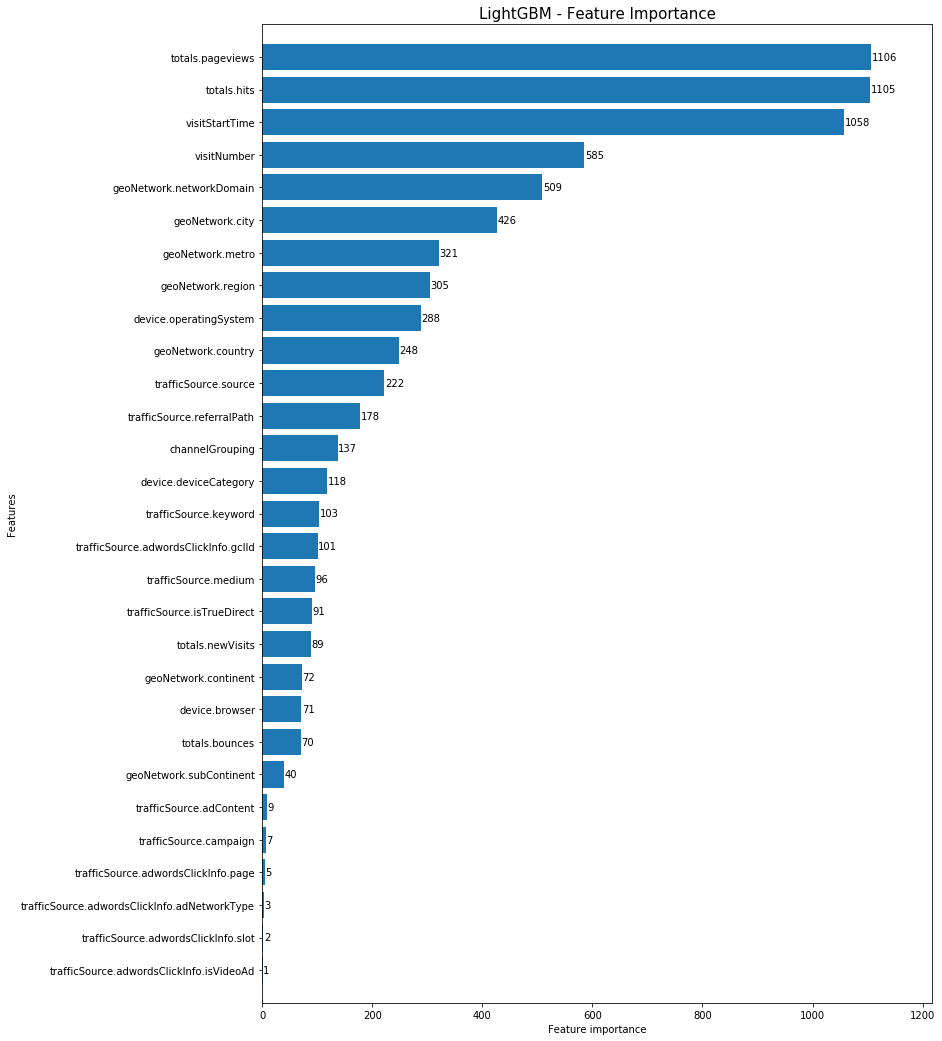

In [126]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

### We can see here that according to LightGBM model, "totals.pageviews" is the most important feature followed by "totals.hits" and "visitStartTime" and so on.

### Now let's try to further analize our model and see what happens when we increase the boosting rounds to 2000.
#### We also changed *verbose_eval* to 50 to see the difference in values in a better way.

In [135]:
def run_lgb2(train_X, train_y, validation_X, validation_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(validation_X, label=validation_y)
    model = lgb.train(params, lgtrain, 2000, valid_sets=[lgval], early_stopping_rounds=500, verbose_eval=50)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(validation_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

In [136]:
%%time
pred_test2, model2, pred_val2 = run_lgb2(development_X, development_y, validation_X, validation_y, test_X)

Training until validation scores don't improve for 500 rounds.
[50]	valid_0's rmse: 1.70379
[100]	valid_0's rmse: 1.69586
[150]	valid_0's rmse: 1.69238
[200]	valid_0's rmse: 1.69126
[250]	valid_0's rmse: 1.69095
[300]	valid_0's rmse: 1.69175
[350]	valid_0's rmse: 1.69263
[400]	valid_0's rmse: 1.69449
[450]	valid_0's rmse: 1.69487
[500]	valid_0's rmse: 1.69769
[550]	valid_0's rmse: 1.69916
[600]	valid_0's rmse: 1.70036
[650]	valid_0's rmse: 1.70098
[700]	valid_0's rmse: 1.70235
[750]	valid_0's rmse: 1.70328
Early stopping, best iteration is:
[254]	valid_0's rmse: 1.69087
CPU times: user 1min 20s, sys: 1.3 s, total: 1min 22s
Wall time: 22.7 s


#### Let's compute the evaluation metric on this new validation data. 

In [137]:
from sklearn import metrics
pred_val2[pred_val2<0] = 0
validation_pred_df = pd.DataFrame({"fullVisitorId":validation_df["fullVisitorId"].values})
validation_pred_df["transactionRevenue"] = validation_df["totals.transactionRevenue"].values
validation_pred_df["PredictedRevenue"] = np.expm1(pred_val2)

validation_pred_df = validation_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(validation_pred_df["transactionRevenue"].values), np.log1p(validation_pred_df["PredictedRevenue"].values))))

1.709925685736863


#### Here, we got a validation score of 1.70 using the new method, which is the same as the previous one.
We can see that our best iteration remains to be iteration number **254**

### Now let's try to build a new model - XGBoost (Extreme Grandient Boosting)

In [204]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return round(np.sqrt(mean_squared_error(y_true, y_pred)), 5)

def run_xgb(X_train, y_train, X_val, y_val, X_test):
    params = {'objective': 'reg:linear',
              'eval_metric': 'rmse',
              'eta': 0.001,
              'max_depth': 10,
              'subsample': 0.6,
              'colsample_bytree': 0.6,
              'alpha':0.001,
              'random_state': 42,
              'silent': True}

    xgb_train_data = xgb.DMatrix(X_train, y_train)
    xgb_val_data = xgb.DMatrix(X_val, y_val)
    xgb_submit_data = xgb.DMatrix(X_test)

    model = xgb.train(params, xgb_train_data, 
                      num_boost_round=1000, 
                      evals= [(xgb_train_data, 'train'), (xgb_val_data, 'valid')],
                      early_stopping_rounds=100, 
                      verbose_eval=200
                     )

    pred_train_y = model.predict(xgb_train_data, ntree_limit=model.best_ntree_limit)
    pred_val_y = model.predict(xgb_val_data, ntree_limit=model.best_ntree_limit)
    pred_test_y = model.predict(xgb_submit_data, ntree_limit=model.best_ntree_limit)

    print(f"XGB : RMSE val: {rmse(y_val, pred_val_y)}  - RMSE train: {rmse(y_train, pred_train_y)}")
    return pred_test_y, model, pred_val_y

In [205]:
%%time
xgb_pred_test, xgb_model, xgb_pred_val = run_xgb(development_X, development_y, validation_X, validation_y, test_X)

[0]	train-rmse:1.99812	valid-rmse:2.14661
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[200]	train-rmse:1.89528	valid-rmse:2.04636
[400]	train-rmse:1.81684	valid-rmse:1.97075
[600]	train-rmse:1.75365	valid-rmse:1.91202
[800]	train-rmse:1.70368	valid-rmse:1.86657
[999]	train-rmse:1.66151	valid-rmse:1.82999
XGB : RMSE val: 1.82999  - RMSE train: 1.66151
CPU times: user 22min 43s, sys: 5.73 s, total: 22min 49s
Wall time: 23min


In [208]:
xgb_pred_val[xgb_pred_val<0] = 0
validation_pred_df2 = pd.DataFrame({"fullVisitorId":validation_df["fullVisitorId"].values})
validation_pred_df2["transactionRevenue"] = validation_df["totals.transactionRevenue"].values
validation_pred_df2["PredictedRevenue"] = np.expm1(xgb_pred_val)

validation_pred_df2 = validation_pred_df2.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
submit_score2 = np.sqrt(metrics.mean_squared_error(np.log1p(validation_pred_df2["transactionRevenue"].values), np.log1p(validation_pred_df2["PredictedRevenue"].values)))
print(submit_score2)

1.9145157780957418


#### Here, we got a validation score of 1.91 using XGBoost.

### Catboost

In [160]:
from catboost import CatBoostRegressor
def run_catboost(X_train, y_train, X_val, y_val, X_test):
    model = CatBoostRegressor(iterations=1000,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)
    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              use_best_model=True,
              verbose=100)
    
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_submit = model.predict(X_test)

    print(f"CatB: RMSE val: {rmse(y_val, y_pred_val)}  - RMSE train: {rmse(y_train, y_pred_train)}")
    return y_pred_submit, model, y_pred_val

In [161]:
%%time
# Train Catboost and generate predictions
cat_pred_test, cat_model, cat_pred_val = run_catboost(development_X, development_y, validation_X, validation_y, test_X)

0:	learn: 1.9624991	test: 2.1153424	best: 2.1153424 (0)	total: 365ms	remaining: 6m 4s
100:	learn: 1.5895576	test: 1.6966007	best: 1.6966007 (100)	total: 25.1s	remaining: 3m 43s
200:	learn: 1.5504042	test: 1.6931304	best: 1.6930898 (196)	total: 53.4s	remaining: 3m 32s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1.693089773
bestIteration = 196

Shrink model to first 197 iterations.
CatB: RMSE val: 1.69309  - RMSE train: 1.55189
CPU times: user 3min 14s, sys: 17.7 s, total: 3min 31s
Wall time: 1min 7s


In [209]:
cat_pred_val[cat_pred_val<0] = 0
validation_pred_df2 = pd.DataFrame({"fullVisitorId":validation_df["fullVisitorId"].values})
validation_pred_df2["transactionRevenue"] = validation_df["totals.transactionRevenue"].values
validation_pred_df2["PredictedRevenue"] = np.expm1(cat_pred_val)

validation_pred_df2 = validation_pred_df2.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
submit_score3 = np.sqrt(metrics.mean_squared_error(np.log1p(validation_pred_df2["transactionRevenue"].values), np.log1p(validation_pred_df2["PredictedRevenue"].values)))
print(submit_score3)

1.7094433862016563


#### Here, we got a validation score of 1.70 using CatBoost.

### Ensemble method

In [184]:
ensemble_pred_70_30_00 = 0.7 * pred_test + 0.3 * cat_pred_test + 0.0 * xgb_pred_test 
ensemble_pred_70_25_05 = 0.7 * pred_test + 0.25 * cat_pred_test + 0.05 * xgb_pred_test

In [185]:
ensemble_pred_70_30_00_positive = np.where(ensemble_pred_70_30_00 < 0, 0, ensemble_pred_70_30_00)
np.savetxt("ensemble_pred_70_30_00_positive.csv", ensemble_pred_70_30_00_positive, delimiter=",")
ensemble_pred_70_25_05_positive = np.where(ensemble_pred_70_25_05 < 0, 0, ensemble_pred_70_25_05)
np.savetxt("ensemble_pred_70_25_05_positive.csv", ensemble_pred_70_25_05_positive, delimiter=",")

In [186]:
ensemble_pos_result1 = pd.read_csv("ensemble_pred_70_30_00_positive.csv")
ensemble_pos_result2 = pd.read_csv("ensemble_pred_70_25_05_positive.csv")

#### Ensemble results:

In [217]:
ensemble1 = 0.7 * submit_score1 + 0.3 * submit_score3 + 0.0 * submit_score2
ensemble2 = 0.7 * submit_score1 + 0.25 * submit_score3 + 0.05 * submit_score2
ensemble3 = 0.5 * submit_score1 + 0.5 * submit_score3 + 0.0 * submit_score2
ensemble4 = 0.4 * submit_score1 + 0.5 * submit_score3 + 0.01 * submit_score2

In [218]:
print(ensemble1,ensemble2,ensemble3,ensemble4)

1.7097809958763008 1.7200346154710053 1.7096845359692596 1.5578371251765308


### The best ensemble is: ensemble4 with weights 0.4 for LightGBM, 0.5 for CatBoost and 0.01 for XGBoost

## Summary of results (submit scores/ validation scores):
### LightGBM - 1.70
### XGBoost - 1.91
### CatBoost - 1.70
### Ensemble with weights 0.4 for LightGBM, 0.5 for CatBoost and 0.01 for XGBoost - 1.55